<a href="https://colab.research.google.com/github/gabijanag/Client_database_with_UI/blob/master/AI_Churn_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CodeAcademy final project - Churn Model
```
By Gabija Nagrockyte
```



# Introduction

## Dataset
 
### Telcom Customer Churn


Each row represents a customer, each column contains customer’s attributes.

The raw data contains 7043 rows (customers) and 21 columns (features).

Target column - “Churn”.



**The data set includes information about:**

* **Services that each customer has signed up for** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

* **Customer account information** - how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

* **Demographic info about customers** – gender, age range, and if they have partners and dependents

 

 [Click here for more information.](https://www.kaggle.com/blastchar/telco-customer-churn)

In [1]:
import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
sns.set_style("white")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
URL = 'https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/CustomerChurn.xlsx'
df = pd.read_excel(URL)
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Firslty let's have a quick look at the clients IDs and see if we find anything interesting there.

In [3]:
print('\n''\n''\033[1m' + 'Total rows' '\033[0m' + ':', len(df))
print('\n''\033[1m' + 'Total unique clients' '\033[0m' + ':', len(df['Customer ID'].unique()))

loyaltyIDs = len(df['LoyaltyID'].unique())
print('\n''\033[1m' + 'Total unique Loyalty IDs' '\033[0m' + ':', loyaltyIDs)
print('Which means that', len(df)-loyaltyIDs, 'clients share Loyalty IDs.')
print('That is', round((len(df)-loyaltyIDs) * 100 / len(df), 1), '% from all clients.')



Total rows: 7043

Total unique clients: 7043

Total unique Loyalty IDs: 7021
Which means that 22 clients share Loyalty IDs.
That is 0.3 % from all clients.


0.3 % of all clients share the same Loyalty ID's. Most likely these clients are connected to each other through family ties or friendships. If there were a greater percentage, it would be interested to look into the similarity of such profiles and how linked are the churn rates (e.g. if one family member leaves are the linked ones soon to follow). However, since this number is so low we will search for hidden attributes that more greatly affect churn in this specific client base.

## Churn Rate

Our main target variable is the 'Churn' column. Let's find out the percentage of customers who left.

In [4]:
Churn = (df.Churn.value_counts(normalize=True) * 100).round(1)

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = Churn.loc['Yes'],
    number = {'suffix' : '%'},
    mode = "gauge+number",
    title = {'text': "Churn Rate<span style='font-size:10>",
            
            },
    gauge = {'axis': {'range': [None, 100]},
             'bar': {'color': "slateblue"},
             'bgcolor': "white",
             'borderwidth': 2,
             'bordercolor': "gray",
             'steps': [
            {'range': [0, 20], 'color': 'lavender'},
            {'range': [20, 50], 'color': 'ghostwhite'},
            {'range': [50, 100], 'color': 'white'}],
            }))

fig.update_layout(height=350, width=500)
fig.show()

The churn percentage is neither high nor low. From the data quality aspect for modeling, there is a slight imbalance which we will adress later on.

# Data Preprocessing

## Missing Data

**It is important to look at the data types and change it to numeric where possible, because missing values can be hiding in a form of blankspaces. First let's look at the missing data with the data types as is.**

In [5]:
def nans_info(dataframe): 
    nan_cols = dataframe.columns[dataframe.isnull().any()]
    
    if len(nan_cols) == 0:
        print('\n'+ 'No missing data found' + '\n')
        
    else:
        for c in nan_cols:
            na_count = dataframe[c].isna().sum()
            print('\n''\n''\033[1m' + 'Columns that have missing data' + '\033[0m')
            print('\n''\033[4m' + c + '\033[0m' + ' (dtype', dataframe[c].dtype, ')')           
            print(f'Missing value count: {na_count}. Percentage from total: {round(na_count * 100 / len(dataframe.index), 1)} %')

        
nans_info(df)


No missing data found



Lets see whether changing the data type of columns that are supposed to be numeric will lead to a different result.

In [6]:
df.dtypes

LoyaltyID              int64
Customer ID           object
Senior Citizen        object
Partner               object
Dependents            object
Tenure                 int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn                 object
dtype: object

Since Monthly Charges and Total Charges have to be numeric, this is going to be changed.

In [6]:
'''Changing numeric data into a correct data type 
Select columns with an indicating keyword in the column names.'''

def dtype_change_to_num(dataframe, keyword):
    
    # Select appopriate columns by keyword
    Num_cols = [col for col in dataframe.columns if keyword in col]
    
    # Change dtype to numeric where possible
    print('\n''\n''\033[1m' + 'Columns that have been changed to numeric' + '\033[0m', )
    for col in Num_cols:
        print('\n''\033[4m' + col + '\033[0m' + '. Original dtype\033[3m', dataframe[col].dtype, '\033[0m')   
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
        print('changed into\033[3m', dataframe[col].dtype) 

In [7]:
dtype_change_to_num(df, 'Charges')



Columns that have been changed to numeric

Monthly Charges. Original dtype float64 
changed into float64

Total Charges. Original dtype object 
changed into float64


In [8]:
nans_info(df)



Columns that have missing data

Total Charges (dtype float64 )
Missing value count: 11. Percentage from total: 0.2 %


Even though there are only 0.2 % of data missing, since we have just over 7000 rows of data, we will opt for saving them instead of simply dropping. Missing values will be replaced to median values

In [9]:
def imp_nans(dataframe, strategy='median'):
        
    '''Missing values in numerical columns are filled with selected strategy'''
    from sklearn.impute import SimpleImputer
           
    imp_int = SimpleImputer(missing_values=np.nan, strategy=strategy)
    nan_cols = dataframe.columns[dataframe.isnull().any()]
    
    for c in nan_cols:
        imp = imp_int.fit(dataframe[[c]]) 
        dataframe[c]=imp.transform(dataframe[[c]])

In [10]:
imp_nans(df, strategy='median')

**Final check for missing data**

In [11]:
nans_info(df)


No missing data found



## Feature Visualization

ID columns are not going to be needed further on. For example "Customer ID" is a combination of numbers and letters, that would create an extremely high cardinality (one for each ID) if encoded. Furthermore, it's hard to derive insights from it. So a simple drop will do.

In [12]:
df = df.drop(columns=['Customer ID', 'LoyaltyID'])

The feature "Payment Method" has "(authomatic)" included in some method names, which gives no additional information, so let's remove that.

In [13]:
# Remove (automatic) from payment method names
df['Payment Method'] = df['Payment Method'].str.replace(' (automatic)', '', regex=False)

Let's check the distribution of categorical features in relation to churn.

In [14]:
def cat_feature_plots (cols, title, colors = 'preset'):

    # Colors for columns in sns countplot
    if colors == 'preset':
        color_pal = ["light blue", "pale teal", "light periwinkle", "silver", "light peach"]
        sns.set_palette(sns.xkcd_palette(color_pal))
        
    else:
        sns.set_palette(sns.xkcd_palette(colors))

    # Define figure specs
    columns = 3
    rows = int(math.ceil((len(cols) / columns)))
    fig_height = 5 * rows
    fig, axes = plt.subplots(rows, columns, figsize=(30, fig_height))
    fig.suptitle(title, fontsize=20)

    # Plot
    for ax, col in zip(axes.flat, cols):

        #Category counts in columns
        sns.countplot(x=df[col], ax=ax, order=df[col].value_counts().index)
        ax.set_title(col, fontsize=15) #Set title above each subplot
        ax.set_xlabel('')  #Remove xaxis title
        ax.set_ylabel('Clients')
        ax.set_ylim([0, 6500])  #maximum height of columns

        #Calculate Churn rate
        data = df[[col, 'Churn']].groupby(col)['Churn'].value_counts().unstack()
        data['Churn_Rate'] = ((data['Yes']  / (data['No'] + data['Yes'] ))*100).round(0)

        #Add churn rates on secondary y axis
        ax2 = ax.twinx() 
        sns.lineplot(x=data.index, y=data['Churn_Rate'], ax = ax2, color='red', markers=True)
        #Add annotations on markers
        [ax2.text(p[0]
                , p[1]+6 #annotation height above marker
                , p[1]
                , color='red') for p in zip(ax2.get_xticks(), data['Churn_Rate'])]

        ax2.set_ylim([0, 100])  


    # Remove empty plots:
    empty_plots_count = (rows * columns) - len(cols)
    if empty_plots_count != 0:
        empty_plots_location = list(range(-1, -abs(empty_plots_count) - 1, -1))
        for i in empty_plots_location:
            axes.flat[i].set_visible(False) 

    plt.show()

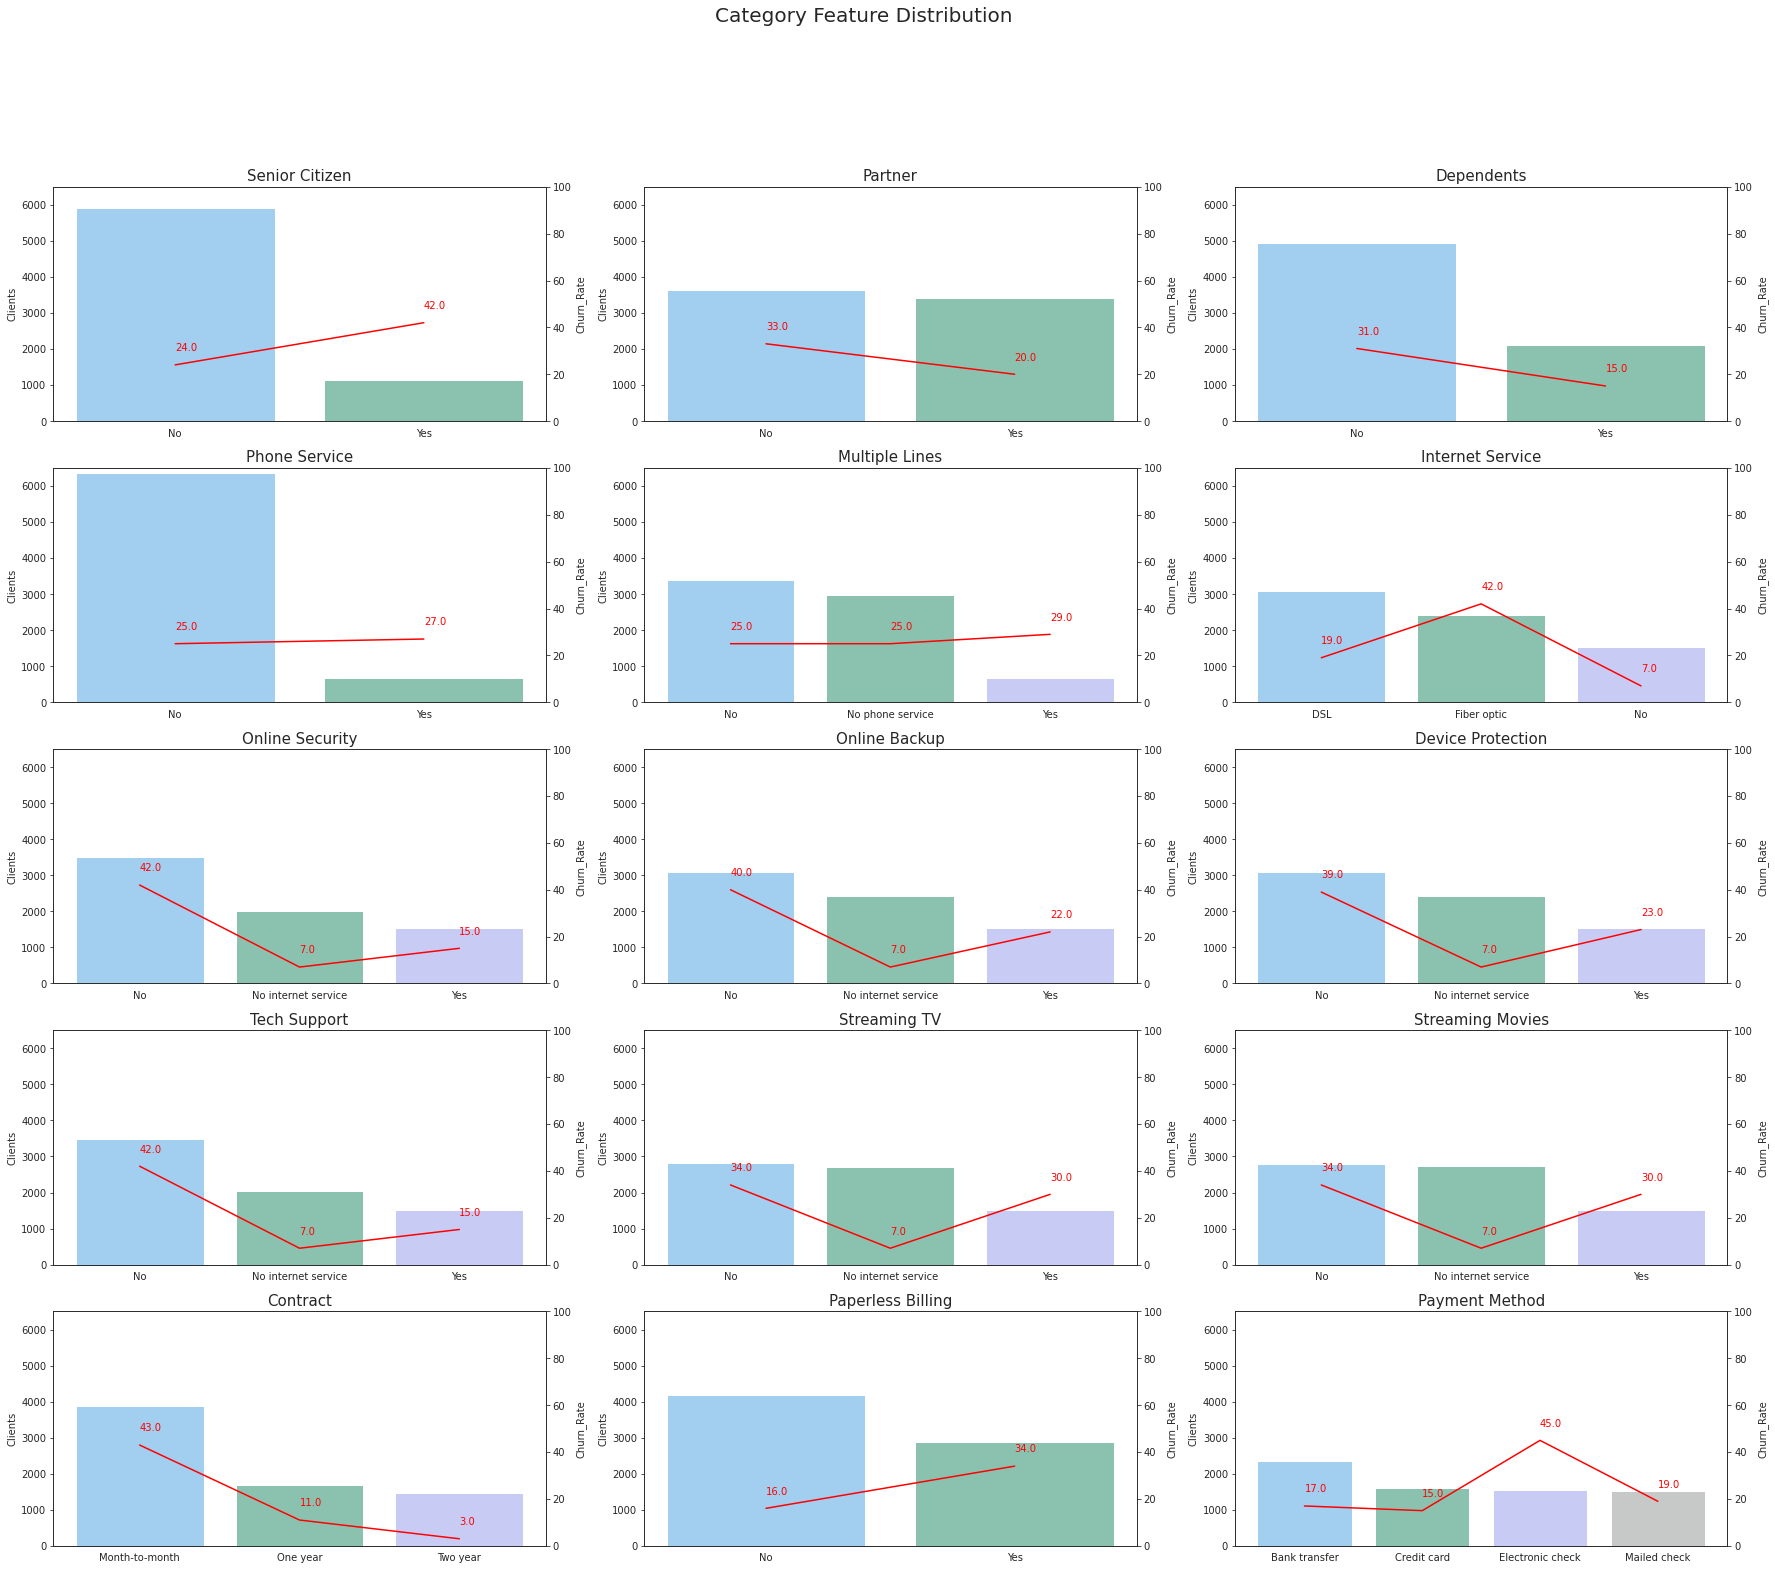

In [15]:
#Select category features except for target
cat_cols = df.columns[df.dtypes == 'object']
category_cols = [x for x in cat_cols if x != "Churn"]

# Plot
Title = "Category Feature Distribution"
cat_feature_plots (category_cols, Title, colors = 'preset')

Having looked at the categorical feature distribution in relation to Churn customer categories that have a high tendency to churn:

* Clients with Payment Method - Electronic check
* Clients with Month-To-Month contracts
* Senior citizens
* Clients with Internet Service type - Fiber Optic
* Clients with No Online Security
* Clients with No Tech Support


## Feature Creation

In [16]:
df['Independent Senior'] = np.where((df['Senior Citizen'] == 'Yes') & 
                                    (df['Partner'] == 'Yes') & 
                                    (df['Dependents'] == 'Yes'), 'Yes', 'No')


df['Payment Credit Card Paperless'] = np.where((df['Payment Method']=='Credit card') & (df['Paperless Billing']=='Yes'), 1,0)
df['Service Protection'] = np.where((df['Tech Support']=='Yes') & 
                                    (df['Device Protection']=='Yes') & 
                                    (df['Online Security']=='Yes'), 'Yes', 'No')

In [17]:
# We can imply these as additional services since 'No Phone Service', 'No Internet Service' are included in the values 
df['Additional Services'] = (df[['Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                                 'Streaming TV', 'Streaming Movies']] == 'Yes').sum(axis=1)

In [18]:
def countplot(x, y):

    plots = {1:[111], 2:[121,122], 3:[131, 132, 133], 4:[221,222,223,224],
             5:[231,232,233,234,235], 6:[231,232,233,234,235,236]}

    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])

    plt.figure(figsize=(7*columns, 7*rows))

    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.countplot(x=j, hue=x, data=df, palette='Blues'
        , alpha=0.8, linewidth=0.4, edgecolor='black')

        ax.set_title(j)

    return plt.show()

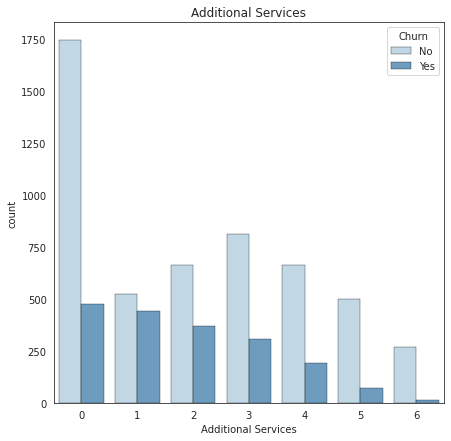

In [19]:
countplot('Churn', ['Additional Services'])

To understand the importance of each categorical feature Sklearn mutual information method is used.

The mutual information method extends the notion of correlation to nonlinear relationships since, unlike Pearson’s correlation coefficient, this method is able to detect not only linear relationships but also nonlinear ones.

In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable. Higher values of mutual information show a higher degree of dependency which indicates that the independent variable will be useful for predicting the target.

In [20]:
# function that computes the mutual infomation score between a categorical serie and the column Churn
from sklearn import metrics

def compute_mutual_information(categorical_serie):
    return metrics.mutual_info_score(categorical_serie, df.Churn)

# select categorial variables excluding the response variable 
categorical_variables = df.select_dtypes(include=object).drop('Churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

Contract              0.098453
Online Security       0.064677
Tech Support          0.063021
Internet Service      0.055574
Online Backup         0.046792
Payment Method        0.044519
Device Protection     0.043917
Streaming Movies      0.032001
Streaming TV          0.031908
Paperless Billing     0.019194
Dependents            0.014467
Service Protection    0.013598
Partner               0.011454
Senior Citizen        0.010577
Multiple Lines        0.000801
Phone Service         0.000072
Independent Senior    0.000019
dtype: float64


## Encode Binary features

Many machine learning models, such as regression or SVM, are algebraic. This means that their input must be numerical. To use these models, categorical features must be transformed into numbers first, before applying a learning algorithm on them. Hence depending on the nature of a categorical feature different encoding techniques can be applied.

Let's have a quick look at the datasets categorical columns.

In [21]:
dff=df.copy()

In [22]:
dff.select_dtypes(include=['object']).head()

,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn,Independent Senior,Service Protection
0,No,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,No
1,No,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,No,No
2,No,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,No,No
3,No,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,No,No,Yes
4,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,No


In [23]:
#Change variable name separators to '_'
# df.columns = [column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_") for column in df.columns]

Next let's encode the categorical values. There are vast possibilities to do so. But my favourite technique is first checking what Sklearn's LabelEncoder has to propose. The Label Encoder uses number sequencing, which may get tricky since it introduces a sort of relation or weights between the categories, which in some cases may be disleading. Usually it is great for columns with 2 unique values, or ordinal features (e.g. small-medium-big).


A common alternative approach is called One Hot Encoding. The strategy behind it is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly but does have the downside of adding more columns to the data set.


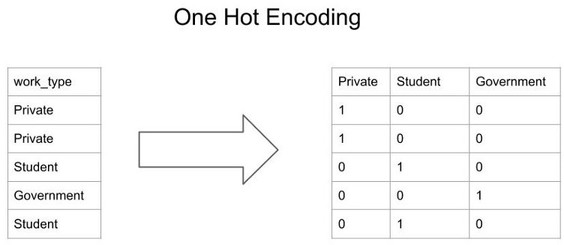

In [24]:
def LE_enc(dataframe):

    # Prep the Encoders
    from sklearn.preprocessing import LabelEncoder
    LE = LabelEncoder()


    '''Change all object dtypes to category for the Label Encoder'''
    obj_cols = dataframe.columns[dataframe.dtypes == 'object']
    for col in obj_cols:
        dataframe[col] = dataframe[col].astype('category') 
                

    '''Encode the binary categorical columns'''
    cat_cols = dataframe.columns[dataframe.dtypes == 'category']
    binary_cols = dataframe.columns[dataframe.nunique() == 2]
    final_binary = set(cat_cols).intersection(binary_cols)

    for col in final_binary:     
        # Print how the labels are encoded
        LE.fit(dataframe[col])
        LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
        print(f'{col} labels:\n{LE_name_mapping}\n')
        dataframe[col] = LabelEncoder().fit_transform(dataframe[col])
    print('Successfully encoded binary columns\n\n')


    '''Print out the Proposed label encodings for multiselection columns
     to get a feel for what type of encoder to use'''

    multi_cols = set(cat_cols) ^ set(final_binary)
    for col in multi_cols:
        LE = LabelEncoder()
        LE.fit(dataframe[col])
        LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
        print(f'{col} labels:\n{LE_name_mapping}\n')
        

LE_enc(dff)

Dependents labels:
{'No': 0, 'Yes': 1}

Senior Citizen labels:
{'No': 0, 'Yes': 1}

Paperless Billing labels:
{'No': 0, 'Yes': 1}

Independent Senior labels:
{'No': 0, 'Yes': 1}

Service Protection labels:
{'No': 0, 'Yes': 1}

Phone Service labels:
{'No': 0, 'Yes': 1}

Partner labels:
{'No': 0, 'Yes': 1}

Churn labels:
{'No': 0, 'Yes': 1}

Successfully encoded binary columns


Contract labels:
{'Month-to-month': 0, 'One year': 1, 'Two year': 2}

Streaming Movies labels:
{'No': 0, 'No internet service': 1, 'Yes': 2}

Payment Method labels:
{'Bank transfer': 0, 'Credit card': 1, 'Electronic check': 2, 'Mailed check': 3}

Device Protection labels:
{'No': 0, 'No internet service': 1, 'Yes': 2}

Streaming TV labels:
{'No': 0, 'No internet service': 1, 'Yes': 2}

Internet Service labels:
{'DSL': 0, 'Fiber optic': 1, 'No': 2}

Multiple Lines labels:
{'No': 0, 'No phone service': 1, 'Yes': 2}

Tech Support labels:
{'No': 0, 'No internet service': 1, 'Yes': 2}

Online Security labels:
{'No': 0,

There are important nominal categorical features so opting for the One Hot encoder techique. But first let's create some additional features  for simplicity sake of the naming.

In [25]:
'''One Hot encode nominal features'''
def OH_enc(dataframe):

    #Select remaining category features
    nominal_cols = dataframe.columns[dataframe.dtypes == 'category']

    #Encode
    for col in nominal_cols:
        one_hot = pd.get_dummies(dataframe[col], prefix=col + '_')
        dataframe = dataframe.drop(columns=[col]) #Drop the remaining column, that is now encoded
        dataframe = dataframe.join(one_hot) #Join the encoded df

OH_enc(dff)

In [26]:
'''One Hot encode nominal features'''
#Select remaining category features
nominal_cols = dff.columns[dff.dtypes == 'category']

#Encode
for col in nominal_cols:
    one_hot = pd.get_dummies(dff[col], prefix=col + '_')
    dff = dff.drop(columns=[col]) #Drop the remaining column, that is now encoded
    dff = dff.join(one_hot) #Join the encoded df


In [27]:
dff.head()

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Churn,Independent Senior,Payment Credit Card Paperless,Service Protection,Additional Services,Multiple Lines__No,Multiple Lines__No phone service,Multiple Lines__Yes,Internet Service__DSL,Internet Service__Fiber optic,Internet Service__No,Online Security__No,Online Security__No internet service,Online Security__Yes,Online Backup__No,Online Backup__No internet service,Online Backup__Yes,Device Protection__No,Device Protection__No internet service,Device Protection__Yes,Tech Support__No,Tech Support__No internet service,Tech Support__Yes,Streaming TV__No,Streaming TV__No internet service,Streaming TV__Yes,Streaming Movies__No,Streaming Movies__No internet service,Streaming Movies__Yes,Contract__Month-to-month,Contract__One year,Contract__Two year,Payment Method__Bank transfer,Payment Method__Credit card,Payment Method__Electronic check,Payment Method__Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,0,0,0,0,2,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,0,0,0,2,1,1,53.85,108.15,1,0,0,0,2,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,45,0,0,42.30,1840.75,0,0,0,1,3,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,2,1,1,70.70,151.65,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Feature Selection


### Display collinear pairs


In [28]:
# Check if there are any collinear features
def check_pairs(dataframe):
    '''Display top 10 most correlation pairs'''
    corr_matrix = dataframe.corr().abs()
    pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                     .astype(bool)).stack().sort_values(ascending=False)).head(20)
    print(pairs)

check_pairs(dff)

Phone Service                           Multiple Lines__No phone service          1.0
Device Protection__No internet service  Tech Support__No internet service         1.0
Internet Service__No                    Device Protection__No internet service    1.0
Tech Support__No internet service       Streaming TV__No internet service         1.0
Internet Service__No                    Tech Support__No internet service         1.0
                                        Streaming TV__No internet service         1.0
                                        Streaming Movies__No internet service     1.0
Online Security__No internet service    Online Backup__No internet service        1.0
                                        Device Protection__No internet service    1.0
                                        Tech Support__No internet service         1.0
                                        Streaming TV__No internet service         1.0
                                        Streaming Movi

All the values with high collinearity would be removed (>0.9)

In [29]:
# Deal with Multicollinearity
def drop_collinear_pairs(dataframe):
    
    '''Drops one column from each of the collinear pairs'''
    corr_matrix = dataframe.drop('Churn', axis=1).corr().abs()

    # Select upper triangle of correlation matrix without diagonal (k = 1)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)] #Drop columns with high collinearity
    dataframe.drop(to_drop, axis=1, inplace=True)
    print(f'Deleted {len(to_drop)} multicollinear columns: \n {to_drop} \n')
    
    
drop_collinear_pairs(dff)

Deleted 7 multicollinear columns: 
 ['Multiple Lines__No phone service', 'Online Security__No internet service', 'Online Backup__No internet service', 'Device Protection__No internet service', 'Tech Support__No internet service', 'Streaming TV__No internet service', 'Streaming Movies__No internet service'] 



### Backward elimination

The lower the p-value, the better the chance the null hypothesis can be rejected. Non significant values where p values is higher than 0.05 should be removed, since it implicates that the variable does not have significant impact on the target variable

In [30]:
def xy(dataframe):
    
#     dataframe = dataframe.select_dtypes(exclude=['datetime', 'timedelta'])
    dataframe = dataframe.select_dtypes(include=['number'], exclude=['datetime', 'timedelta'])
    X = dataframe.loc[:, dataframe.columns != 'Churn'] 
    y = dataframe['Churn']

    return X, y

X, y = xy(dff)

In [32]:
# import statsmodels.api as sm
# #Backward Elimination
# cols = list(X.columns)
# pmax = 1
# while (len(cols)>0):
#     p= []
#     X_1 = X[cols]
#     X_1 = sm.add_constant(X_1)
#     model = sm.OLS(y,X_1).fit()
#     p = pd.Series(model.pvalues.values[1:],index = cols)      
#     pmax = max(p)
#     feature_with_p_max = p.idxmax()
#     if(pmax>0.05):    #if the the highest p column's p is >0.05, remove the column
#         print(feature_with_p_max, 'will be removed with p value', pmax)
#         cols.remove(feature_with_p_max)
#     else:
#         break

# Modeling

In order to test Machine Learning performance, various machine learning algorithms will be tested to select the most effective ML model.

## Split data

Tested:
* Simple Train Test split
* Stratified Train Test split
* Stratified KFold split (Shuffled and Unshuffled; 2, 3, 5 and 10 splits)
* Stratified Shuffle split
* Repeated Stratified KFold
Chose Stratified split.

Stratification maintains the original percentages from the data both in the test and train sets.

In [31]:
from sklearn.model_selection import StratifiedKFold

def split(X, y, scale=False):
    
    '''Stratified Cross Validation - Since churn classes are imbalanced.'''
    kfold = StratifiedKFold(n_splits=5       #Best 5 and 10
                            , shuffle=True   #Shuffles data before making splits
                            , random_state=42) #Ensures splits to be reproducible
    y = y.reset_index(drop=True)  #To avoid NaNs

    # Get the train test sets in 80% and 20% proportion
    if scale == True:
        for train_ix, test_ix in kfold.split(X, y):
            X_train, X_test = X[train_ix], X[test_ix]
            y_train, y_test = y[train_ix], y[test_ix] 
    else:
        for train_ix, test_ix in kfold.split(X, y):
            X_train, X_test = X.iloc[list(train_ix)], X.iloc[list(test_ix)]
            y_train, y_test = y.iloc[list(train_ix)], y.iloc[list(test_ix)] 
               
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split(X, y)

## Sampling for Class imbalance

Tested:
    * RandomOverSampler (sampling_strategy = 'minority',  0.5(best) and 1)
    * RamdomUnderSampler (sampling_strategy = 0.5(best), 1 and 'majority')
    * SMOTE (sampling_strategy=0.5 (best), 'auto', 'minority')
    * BorderlineSMOTE   (very time consuming)
    * Adaptive Synthetic Sampling - ADASYN (also very time consuming)

In [34]:
def over_sample(X_train, y_train):
    
    from imblearn.over_sampling import SMOTE
    oversample = SMOTE(sampling_strategy=0.5)
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    return X_train, y_train


# X_train, y_train = over_sample(X_train, y_train)

## Selection of ML models

All the main ML models will be tested to select the most significant model. Standar Scaler will be used to standardize features by removing the mean and scaling to unit variance. Moreover, Pipeline from sklearn will be used to include pipeline of transforms with a final estimator. Kfold will be used for cross-validator.

In [32]:
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, RandomTreesEmbedding

from sklearn.utils import class_weight

from sklearn.metrics import precision_recall_curve, f1_score, auc, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

Defining a pipeline for testing various popular ML models


In [38]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([
                       ("Scaler", StandardScaler()), 
             ("LogReg", LogisticRegression())])))

clfs.append(("RandomForestClassifier", 
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("XGBClassifier",
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier())]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([
                       ("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

As scoring, recall is selected since it is more relevant for unbalanced data models

In [39]:
scoring = 'recall'
n_folds = 10
results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, shuffle = True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)

LogReg: 0.554184 (+/- 0.040659)
RandomForestClassifier: 0.483193 (+/- 0.034509)
XGBClassifier: 0.524786 (+/- 0.030847)
KNN: 0.517849 (+/- 0.029929)
DecisionTreeClassifier: 0.489512 (+/- 0.027167)
GradientBoostingClassifier: 0.521294 (+/- 0.032003)
RidgeClassifier: 0.519184 (+/- 0.032677)
BaggingRidgeClassifier: 0.457694 (+/- 0.041241)
ExtraTreesClassifier: 0.480554 (+/- 0.023359)


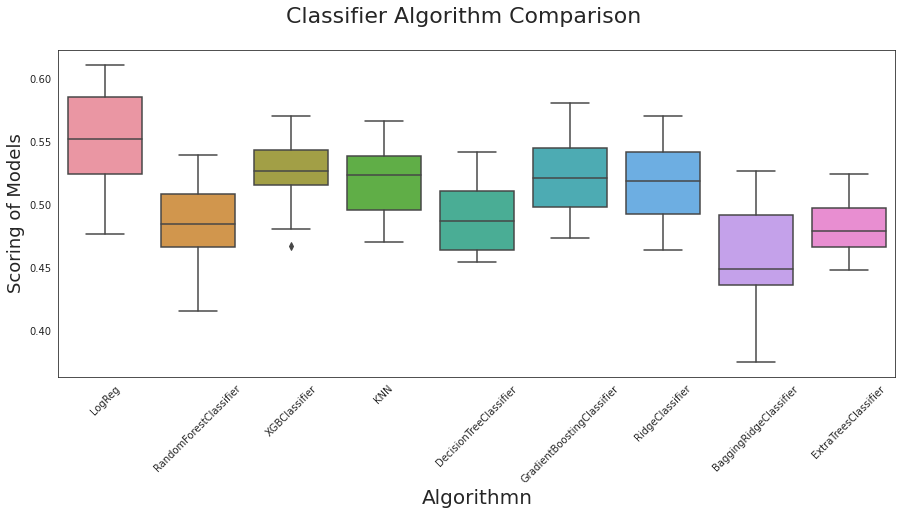

In [40]:
# Pepare data in the right format for boxplot comparison
df_boxplot = pd.DataFrame(columns=['names', 'results'])
i = 0
for x in range(len(results)):
  for y in results[x]:
    df_boxplot.loc[i, 'names'] = names[x]
    df_boxplot.loc[i, 'results'] = y
    i = i + 1
df_boxplot['results'] = df_boxplot['results'].astype(float)

# Plor
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='names', y='results', data=df_boxplot)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Scoring of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()

From the performance, Logistic Regression has the highest value and it will be selected for the further analysis

## Train Model - Machine Learning (Logistic Regression)
Since the best performance is Logistic Regression, it is selected for further analysis.

In [41]:
def train(clf_class, **kwargs): 
    
    # Define the model
    clf = clf_class(**kwargs) 

    # Train the model    
    clf.fit(X_train, y_train)
    
    # Predict class labels and probabilities
#     y_pred = clf.predict(X_test)  #Predicted class labels. Default threshold 0.5
    
    y_pred = (clf.predict_proba(X_test)[:,1] >= 0.33).astype(bool)  #Predicted class labels. Change threshold
    y_prob = clf.predict_proba(X_test) #Predicted probabilities
    
    # For PR AUC
    prec, recall, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    
    
    return clf, y_pred, y_prob, prec, recall, thresholds

**Precision and Recall**


* Precision – Of all the users that the algorithm predicts will churn, how many of them do actually churn?
* Recall – What percentage of all users that end up churning does the algorithm successfully find?

In [43]:
lr, y_pred_lr, y_prob_lr, prec_lr, recall_lr, thresholds_lr= train(LogisticRegression,
                                                        C=10, max_iter=1500
                                                        , solver='liblinear'
                                                        , random_state=42)

rf, y_pred_rf, y_prob_rf, prec_rf, recall_rf, thresholds_rf= train(RandomForestClassifier
                                                                   , n_estimators=200
                                                                   , max_depth=50
                                                                   , random_state=42)

'''Model results'''
# Logistic Regression
print(f'\n\nClassification reports\n')
print(f'Logistic Regression:\n\n{classification_report(y_test, y_pred_lr)}')
print(f'\nF1 score:   {f1_score(y_test, y_pred_lr).round(2)}')
print(f'PR AUC:     {auc(recall_lr, prec_lr).round(2)}')

# Random forest
print(f'\n\n')
print(f'Random forest:\n\n{classification_report(y_test, y_pred_rf)}')
print(f'\nF1 score:   {f1_score(y_test, y_pred_rf).round(2)}')
print(f'PR AUC:     {auc(recall_rf, prec_rf).round(2)}')



Classification reports

Logistic Regression:

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1034
           1       0.53      0.71      0.61       374

    accuracy                           0.76      1408
   macro avg       0.71      0.74      0.72      1408
weighted avg       0.79      0.76      0.77      1408


F1 score:   0.61
PR AUC:     0.64



Random forest:

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1034
           1       0.55      0.67      0.60       374

    accuracy                           0.77      1408
   macro avg       0.71      0.74      0.72      1408
weighted avg       0.78      0.77      0.77      1408


F1 score:   0.6
PR AUC:     0.6


Check if the predicted churn rate is similar to the actual churn rate

In [47]:
# Actual vs predicted
dff['predicted_class'] = rf.predict(X)
# According to the predicted class choose the probability  
probability = rf.predict_proba(X)
dff['probability'] = np.where(dff['predicted_class'] == 1, probability[:,1], probability[:,0])
dff['churn_probability'] = probability[:,1].round(1)


# Check the predicted churn rate
dff['predicted_class'].value_counts(normalize=True)

0    0.747693
1    0.252307
Name: predicted_class, dtype: float64

Next let's see how Precision-Recall performs against threshold to decide if we can adjust it for higher performance.

In [48]:
def threshold_plot(thresholds, prec, recall, modelname):

    title = 'Precision-Recall vs Threshold @' + str(modelname)
    plt.title(title)
    plt.plot(thresholds, prec[: -1], 'b--', label='Precision')
    plt.plot(thresholds, recall[: -1], 'r--', label='Recall')
    plt.ylabel('Precision, Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([0,1])

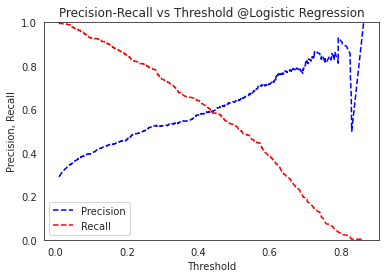

In [49]:
threshold_plot(thresholds_lr, prec_lr, recall_lr, 'Logistic Regression')

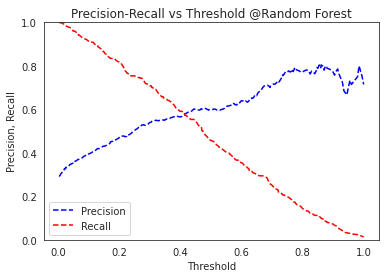

In [50]:
threshold_plot(thresholds_rf, prec_rf, recall_rf, 'Random Forest')

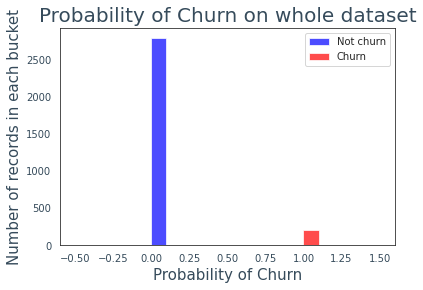

In [58]:
'''Probability distribution'''
import matplotlib.pyplot as plt

prediction=(rf.predict_proba(X)[:,1]).round(1)

# Add color around the plot for PPT 
# plt.figure(figsize=(8, 5)).patch.set_facecolor('#FEF6E0') 

plt.hist(prediction[prediction==0], label='Not churn', alpha=0.7, color='b')
plt.hist(prediction[prediction==1], label='Churn', alpha=0.7, color='r')
plt.xlabel('Probability of Churn', color='#364B5B', fontsize=15)
plt.ylabel('Number of records in each bucket', color='#364B5B', fontsize=15)
plt.legend()
plt.tick_params(axis='both', pad=5)

# Color params
plt.title('Probability of Churn on whole dataset', fontsize=20, color='#364B5B')
plt.tick_params(color='#364B5B', labelcolor='#364B5B')

plt.show() 

### Machine Learning Feature Importance

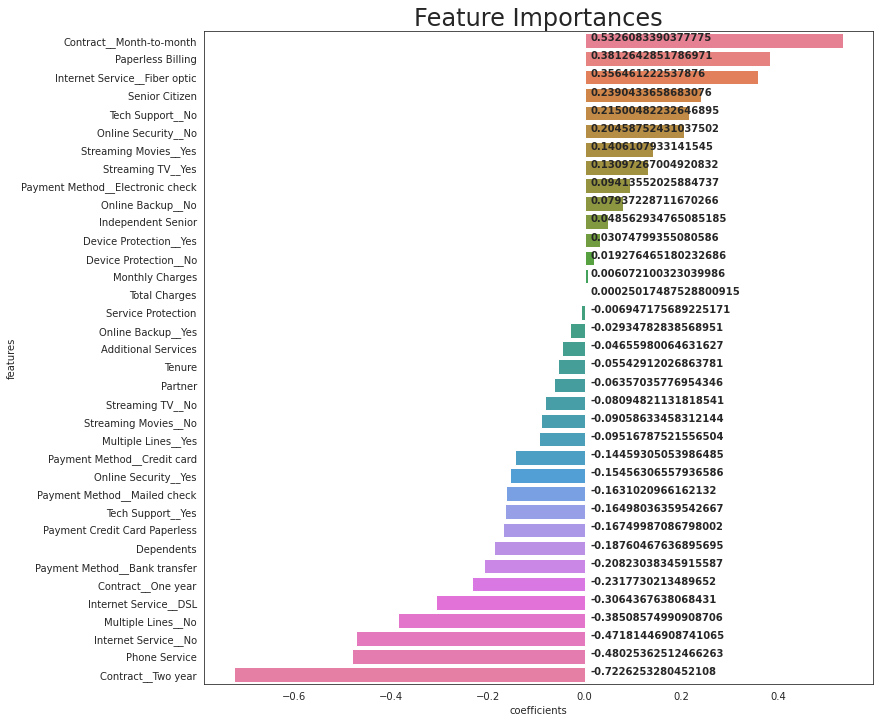

In [59]:
plt.rcParams["figure.figsize"]=12,12

ml_df = pd.DataFrame(lr.coef_[0],X_train.columns).reset_index()
ml_df = ml_df.rename(columns={"index":"features",0:"coefficients"})
ml_df = ml_df.sort_values(by="coefficients",ascending = False)
ax = sns.barplot(x = "coefficients" ,y ="features",data=ml_df,palette="husl")
plt.title("Feature Importances",fontsize =24)
for i,j in enumerate(ml_df["coefficients"]):
    ax.text(.011,i,j,weight = "bold")

By the given features, with the model, it defines that:
*  Increase odds for ...
*  Low impact ...
*  Decrease odds for ...

# Feature Importances - Summary of both Models

First, comparing both models and checking with comparison

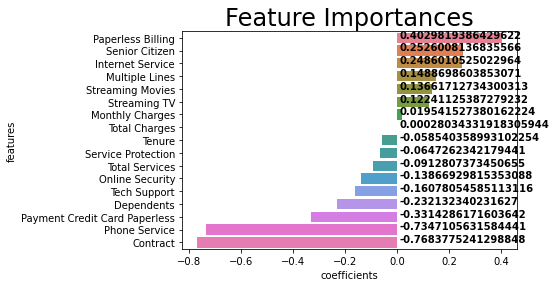

In [ ]:
ax = sns.barplot(x = "coefficients" ,y ="features",data=ml_df,palette="husl")
plt.title("Feature Importances",fontsize =24)
for i,j in enumerate(ml_df["coefficients"]):
    ax.text(.011,i,j,weight = "bold")

In [ ]:
df_fi.sort_values('feature_importance', ascending=False)

,feature_names,feature_importance,std
2,Tenure,0.1264,0.0044
12,Monthly Charges,0.0290,0.0023
13,Total Charges,0.0156,0.0019
10,Contract,0.0122,0.0034
7,Tech Support,0.0108,0.0008
16,Total Services,0.0049,0.0014
1,Dependents,0.0031,0.0014
0,Senior Citizen,0.0031,0.0011
11,Paperless Billing,0.0030,0.0010
6,Online Security,0.0028,0.0015


Features with the biggest impact:
* s

## Top 5 % of most likely to churn by the model. NOT SURE IF IT'S NEEDED

Getting probability for churn where if predicted class 1, probability to get 1 or else, probability to get 0

In [ ]:
probability = ml_model.predict_proba(X)
df_top_prep = X.copy
df_top_prep['Churn'] = y
df_top_prep['predicted_class'] = ml_model.predict(X)
df_top_prep['probability'] = np.where(df_top_prep['predicted_class'] == 1, probability[:,1], probability[:,0])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



ValueError: ignored

In [ ]:
X[['predicted_class','probability']].head()

,predicted_class,probability
0,1,0.613031
1,0,0.953778
2,0,0.632344
3,0,0.972478
4,1,0.645420


In [ ]:
percentile = 0.95
quantile_value = df_top_prep['probability'].quantile(percentile)

In [ ]:
df_top = df_top_prep[df_top_prep['probability'] > quantile_value]